# MLB Pitch Outcome Prediction
### Predicting whether a pitch results in a hit using Statcast data
This notebook walks through building a machine learning model from scratch using MLB Statcast data. We'll explore the data, engineer relevant features, train a model, and evaluate its performance.

In [2]:
# Import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pybaseball as pyball

In [60]:
steps_to_follow = [
    "1. Getting the data ready",
    "2. Choose the right estimator/algorithm for our problems",
    "3. Fit the model/algorithm and use it to make predictions on our data",
    "4. Evaluating a model",
    "5. Improve a model",
    "6. Save and load a trained model"
]

## 1. Getting the data ready

In [ ]:
# Let's try grabbing all pitchers for 2025 regular season
# This query will take a while and will prompt a warning that says as much
# Hiding the warning
import warnings
warnings.filterwarnings('ignore')

pitcher_data = pyball.statcast(start_dt='2025-03-27', end_dt='2025-09-28')

This is a large query, it may take a moment to complete


c:\Users\dalli\OneDrive\Desktop\pitch-hit-predictor\venv\Lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/186 [00:00<?, ?it/s]c:\Users\dalli\OneDrive\Desktop\pitch-hit-predictor\venv\Lib\site-packages\pybaseball\datahelpers\postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors`

In [5]:
pitcher_data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
1994,FF,2025-09-28,95.7,-2.15,5.21,"Weissert, Greg",678009,669711,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,Parker Meadows flies out to left fielder Jarre...,R,L,R,BOS,DET,X,7,fly_ball,0,0,2025,-0.71,0.93,-0.4,3.08,<NA>,700242,628451,2,9,Top,96.06,86.56,<NA>,...,3,3,4,3,4,3,4,Infield shade,Strategic,226,0.14,-0.284,69.0,7.1,0.008,0.284,88.0,1,-1,0.86,0.14,30,25,30,26,1,4,2,1,<NA>,<NA>,1.56,0.71,-0.71,20.9,5.991833,-1.319512,28.782516,41.559201,30.599805
2040,FF,2025-09-28,95.1,-1.91,5.1,"Weissert, Greg",668670,669711,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,6,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,2,NaN,0,2,2025,-0.93,0.93,0.57,2.59,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,3,4,3,4,3,4,Standard,Standard,229,0.135,-0.159,<NA>,<NA>,<NA>,0.159,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,1.59,0.93,0.93,20.5,<NA>,<NA>,<NA>,<NA>,<NA>
2165,FF,2025-09-28,95.4,-1.99,5.22,"Weissert, Greg",668670,669711,NaN,foul,<NA>,<NA>,<NA>,<NA>,2,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,2,2025,-0.85,1.14,0.06,3.3,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,3,4,3,4,3,4,Standard,Standard,211,0.0,0.0,63.5,6.2,<NA>,0.0,88.0,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,1.36,0.85,0.85,22.9,2.871131,31.805044,22.266527,37.478847,15.582717
2256,SL,2025-09-28,84.8,-2.33,4.72,"Weissert, Greg",668670,669711,NaN,swinging_strike,<NA>,<NA>,<NA>,<NA>,5,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,1,2025,0.32,0.62,0.14,2.59,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,3,4,3,4,3,4,Standard,Standard,106,0.0,-0.055,72.9,7.6,<NA>,0.055,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,2.55,-0.32,-0.32,12.3,13.78541,4.08139,32.414181,38.011685,27.083341
2352,SL,2025-09-28,85.3,-2.26,4.85,"Weissert, Greg",668670,669711,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,12,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,0,2025,0.52,0.41,0.93,2.57,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,3,4,3,4,3,4,Standard,Standard,98,0.0,-0.033,<NA>,<NA>,<NA>,0.033,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,2.71,-0.52,-0.52,15.8,<NA>,<NA>,<NA>,<NA>,<NA>


In [6]:
type(pitcher_data)

pandas.core.frame.DataFrame

In [7]:
pitcher_data.dtypes

pitch_type                                          object
game_date                                   datetime64[ns]
release_speed                                      Float64
release_pos_x                                      Float64
release_pos_z                                      Float64
                                                 ...      
attack_angle                                       Float64
attack_direction                                   Float64
swing_path_tilt                                    Float64
intercept_ball_minus_batter_pos_x_inches           Float64
intercept_ball_minus_batter_pos_y_inches           Float64
Length: 118, dtype: object

In [8]:
len(pitcher_data)

709459

In [9]:
# Show all columns in the DataFrame
pitcher_data.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'batter_days_until_next_game', 'api_break_z_with_gravity',
       'api_break_x_arm', 'api_break_x_batter_in', 'arm_angle', 'attack_angle',
       'attack_direction', 'swing_path_tilt',
       'intercept_ball_minus_batter_pos_x_inches',
       'intercept_ball_minus_batter_pos_y_inches'],
      dtype='object', length=118)

In [10]:
pitcher_data['player_name'].value_counts()

player_name
Webb, Logan            3282
Rodón, Carlos          3212
Crochet, Garrett       3151
Gallen, Zac            3135
Fried, Max             3109
                       ... 
Kiner-Falefa, Isiah       7
Burleson, Alec            7
Amaya, Jacob              6
Hampson, Garrett          3
McKinstry, Zach           2
Name: count, Length: 873, dtype: int64

In [11]:
# Rename player_name to pitcher_name
pitcher_data.rename(columns={'player_name': 'pitcher_name'}, inplace=True)

In [12]:
# Create batter_name column based on batter column ID using pybaseball's playerid_reverse_lookup function
batter_ids = pitcher_data['batter'].unique()
batter_info = pyball.playerid_reverse_lookup(batter_ids)

Gathering player lookup table. This may take a moment.


In [13]:
batter_info.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,miller,owen,680911,millo002,milleow01,24655,2021.0,2025.0
1,edman,tommy,669242,edmat001,edmanto01,19470,2019.0,2025.0
2,schneider,davis,676914,schnd001,schneda03,23565,2023.0,2025.0
3,durbin,caleb,702332,durbc002,durbica01,-1,2025.0,2025.0
4,lopez,nicky,670032,lopen001,lopezni01,19339,2019.0,2025.0


In [14]:
# Concatenate name_last and name_first to create full name
batter_info['batter_name'] = batter_info['name_last'].str.capitalize() + ', ' + batter_info['name_first'].str.capitalize()
batter_info['batter_name'][:5]

0        Miller, Owen
1        Edman, Tommy
2    Schneider, Davis
3       Durbin, Caleb
4        Lopez, Nicky
Name: batter_name, dtype: object

In [15]:
# Join batter_name back to pitcher_data on 'batter' and 'key_mlbam' in new player_data DataFrame
player_data = pitcher_data.merge(batter_info, how='left', left_on='batter', right_on='key_mlbam')

In [16]:
player_data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last,batter_name
0,FF,2025-09-28,95.7,-2.15,5.21,"Weissert, Greg",678009,669711,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,Parker Meadows flies out to left fielder Jarre...,R,L,R,BOS,DET,X,7,fly_ball,0,0,2025,-0.71,0.93,-0.4,3.08,<NA>,700242,628451,2,9,Top,96.06,86.56,<NA>,...,226,0.14,-0.284,69.0,7.1,0.008,0.284,88.0,1,-1,0.86,0.14,30,25,30,26,1,4,2,1,<NA>,<NA>,1.56,0.71,-0.71,20.9,5.991833,-1.319512,28.782516,41.559201,30.599805,meadows,parker,678009,meadp001,meadopa01,23800,2023.0,2025.0,"Meadows, Parker"
1,FF,2025-09-28,95.1,-1.91,5.1,"Weissert, Greg",668670,669711,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,6,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,2,NaN,0,2,2025,-0.93,0.93,0.57,2.59,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,229,0.135,-0.159,<NA>,<NA>,<NA>,0.159,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,1.59,0.93,0.93,20.5,<NA>,<NA>,<NA>,<NA>,<NA>,rogers,jake,668670,rogej004,rogerja03,19452,2019.0,2025.0,"Rogers, Jake"
2,FF,2025-09-28,95.4,-1.99,5.22,"Weissert, Greg",668670,669711,NaN,foul,<NA>,<NA>,<NA>,<NA>,2,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,2,2025,-0.85,1.14,0.06,3.3,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,211,0.0,0.0,63.5,6.2,<NA>,0.0,88.0,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,1.36,0.85,0.85,22.9,2.871131,31.805044,22.266527,37.478847,15.582717,rogers,jake,668670,rogej004,rogerja03,19452,2019.0,2025.0,"Rogers, Jake"
3,SL,2025-09-28,84.8,-2.33,4.72,"Weissert, Greg",668670,669711,NaN,swinging_strike,<NA>,<NA>,<NA>,<NA>,5,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,1,2025,0.32,0.62,0.14,2.59,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,106,0.0,-0.055,72.9,7.6,<NA>,0.055,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,2.55,-0.32,-0.32,12.3,13.78541,4.08139,32.414181,38.011685,27.083341,rogers,jake,668670,rogej004,rogerja03,19452,2019.0,2025.0,"Rogers, Jake"
4,SL,2025-09-28,85.3,-2.26,4.85,"Weissert, Greg",668670,669711,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,12,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,0,2025,0.52,0.41,0.93,2.57,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,98,0.0,-0.033,<NA>,<NA>,<NA>,0.033,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,2.71,-0.52,-0.52,15.8,<NA>,<NA>,<NA>,<NA>,<NA>,rogers,jake,668670,rogej004,rogerja03,19452,2019.0,2025.0,"Rogers, Jake"


In [17]:
# Let's drop extra columns that got brought over from batter_info
player_data.drop(columns=['name_last', 'name_first', 'key_mlbam', 'key_fangraphs', 'key_bbref', 'mlb_played_first', 'mlb_played_last', 'key_retro'], inplace=True)
player_data.head()

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,pitcher_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,...,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches,batter_name
0,FF,2025-09-28,95.7,-2.15,5.21,"Weissert, Greg",678009,669711,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,1,Parker Meadows flies out to left fielder Jarre...,R,L,R,BOS,DET,X,7,fly_ball,0,0,2025,-0.71,0.93,-0.4,3.08,<NA>,700242,628451,2,9,Top,96.06,86.56,<NA>,...,3,4,3,4,3,4,Infield shade,Strategic,226,0.14,-0.284,69.0,7.1,0.008,0.284,88.0,1,-1,0.86,0.14,30,25,30,26,1,4,2,1,<NA>,<NA>,1.56,0.71,-0.71,20.9,5.991833,-1.319512,28.782516,41.559201,30.599805,"Meadows, Parker"
1,FF,2025-09-28,95.1,-1.91,5.1,"Weissert, Greg",668670,669711,strikeout,called_strike,<NA>,<NA>,<NA>,<NA>,6,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,2,NaN,0,2,2025,-0.93,0.93,0.57,2.59,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,4,3,4,3,4,Standard,Standard,229,0.135,-0.159,<NA>,<NA>,<NA>,0.159,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,1.59,0.93,0.93,20.5,<NA>,<NA>,<NA>,<NA>,<NA>,"Rogers, Jake"
2,FF,2025-09-28,95.4,-1.99,5.22,"Weissert, Greg",668670,669711,NaN,foul,<NA>,<NA>,<NA>,<NA>,2,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,2,2025,-0.85,1.14,0.06,3.3,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,4,3,4,3,4,Standard,Standard,211,0.0,0.0,63.5,6.2,<NA>,0.0,88.0,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,1.36,0.85,0.85,22.9,2.871131,31.805044,22.266527,37.478847,15.582717,"Rogers, Jake"
3,SL,2025-09-28,84.8,-2.33,4.72,"Weissert, Greg",668670,669711,NaN,swinging_strike,<NA>,<NA>,<NA>,<NA>,5,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,1,2025,0.32,0.62,0.14,2.59,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,4,3,4,3,4,Standard,Standard,106,0.0,-0.055,72.9,7.6,<NA>,0.055,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,2.55,-0.32,-0.32,12.3,13.78541,4.08139,32.414181,38.011685,27.083341,"Rogers, Jake"
4,SL,2025-09-28,85.3,-2.26,4.85,"Weissert, Greg",668670,669711,NaN,called_strike,<NA>,<NA>,<NA>,<NA>,12,Jake Rogers called out on strikes.,R,R,R,BOS,DET,S,<NA>,NaN,0,0,2025,0.52,0.41,0.93,2.57,<NA>,700242,628451,1,9,Top,<NA>,<NA>,<NA>,...,3,4,3,4,3,4,Standard,Standard,98,0.0,-0.033,<NA>,<NA>,<NA>,0.033,<NA>,1,-1,0.725,0.275,30,30,30,30,1,3,2,9,<NA>,<NA>,2.71,-0.52,-0.52,15.8,<NA>,<NA>,<NA>,<NA>,<NA>,"Rogers, Jake"


In [18]:
# Let's figure out how we're going to set up a target column
player_data['description'].value_counts()

description
ball                       237985
foul                       127268
hit_into_play              124809
called_strike              115490
swinging_strike             74031
blocked_ball                15122
foul_tip                     7297
swinging_strike_blocked      3990
hit_by_pitch                 1927
foul_bunt                    1245
missed_bunt                   208
pitchout                       54
bunt_foul_tip                  33
Name: count, dtype: int64

In [19]:
# Mapping the outcomes
mapping = {
    'ball': 'Ball',
    'blocked_ball': 'Ball',
    'intent_ball': 'Ball',
    'pitchout': 'Ball',

    'called_strike': 'Called Strike',

    'swinging_strike': 'Swinging Strike',
    'swinging_strike_blocked': 'Swinging Strike',
    'foul_tip': 'Swinging Strike',
    'missed_bunt': 'Swinging Strike',

    'foul': 'Foul',
    'foul_bunt': 'Foul',
    'foul_pitchout': 'Foul',
    'bunt_foul_tip': 'Foul',

    'hit_into_play': 'In Play',

    'hit_by_pitch': 'Hit By Pitch'
}

player_data['target'] = player_data['description'].map(mapping)
player_data['target'].value_counts()

target
Ball               253161
Foul               128546
In Play            124809
Called Strike      115490
Swinging Strike     85526
Hit By Pitch         1927
Name: count, dtype: int64

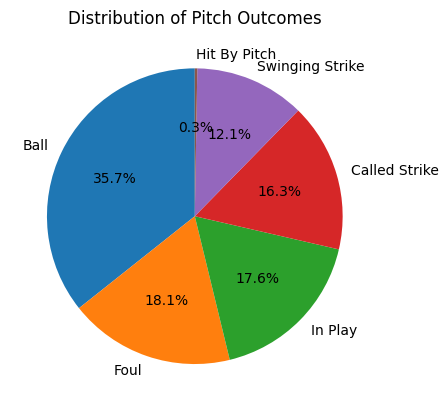

In [20]:
# Let's visualize the target
fig, ax = plt.subplots()
ax.pie(player_data['target'].value_counts(), labels=player_data['target'].value_counts().index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Pitch Outcomes');

In [21]:
# For my own curiosity, let's look into In Play outcomes
player_data[player_data['target'] == 'In Play']['events'].value_counts()

events
field_out                    74248
single                       26102
double                        7737
home_run                      5647
force_out                     3360
grounded_into_double_play     3109
sac_fly                       1291
field_error                   1009
triple                         628
sac_bunt                       560
fielders_choice                387
double_play                    376
fielders_choice_out            325
sac_fly_double_play             15
catcher_interf                  12
triple_play                      3
Name: count, dtype: int64

In [22]:
events_mapping = {
    'single': 'Hit',
    'double': 'Hit',
    'triple': 'Hit',
    'home_run': 'Hit',

    'field_out': 'Out',
    'force_out': 'Out',
    'grounded_into_double_play': 'Out',
    'fielders_choice_out': 'Out',
    'fielders_choice': 'Out',
    'sac_fly': 'Out',
    'sac_fly_double_play': 'Out',
    'sac_bunt': 'Out',
    'double_play': 'Out',
    'triple_play': 'Out',

    'field_error': 'Error',
    'catcher_interf': 'Error'
}

player_data['in_play_result'] = player_data['events'].map(events_mapping)
player_data['in_play_result'].value_counts()

in_play_result
Out      83675
Hit      40114
Error     1095
Name: count, dtype: int64

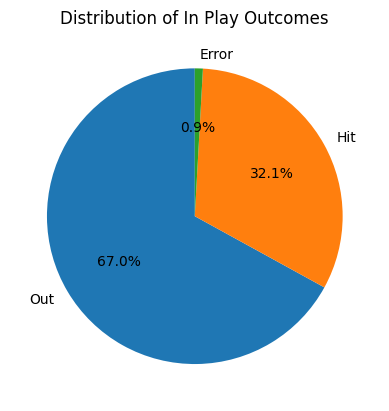

In [23]:
fig, ax = plt.subplots()
ax.pie(player_data['in_play_result'].value_counts(), labels=player_data['in_play_result'].value_counts().index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of In Play Outcomes');

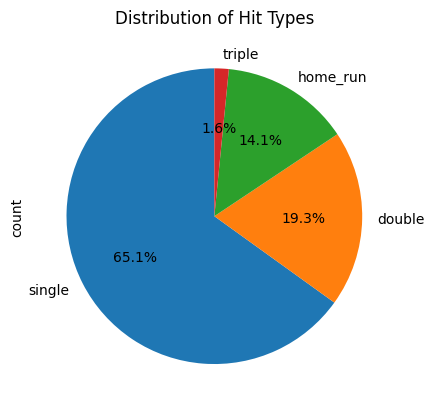

In [24]:
# Pie chart showing distribution of hit types
player_data[player_data['in_play_result'] == 'Hit']['events'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, title='Distribution of Hit Types');

In [25]:
# Let's trim the data down to just what we need for modeling
# Reminder player_name is now pitcher_name
useful_df = player_data[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'pitcher_name', 'batter_name', 'zone', 
                         'p_throws', 'stand', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate', 'release_extension', 'target', 'in_play_result']]

useful_df.head()

,pitch_type,release_speed,release_pos_x,release_pos_y,release_pos_z,pitcher_name,batter_name,zone,p_throws,stand,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,release_extension,target,in_play_result
0,FF,95.7,-2.15,54.67,5.21,"Weissert, Greg","Meadows, Parker",1,R,L,-0.71,0.93,6.169368,-139.262184,-2.088523,-10.601017,31.025947,-19.832498,2370,5.8,In Play,Out
1,FF,95.1,-1.91,53.86,5.1,"Weissert, Greg","Rogers, Jake",6,R,R,-0.93,0.93,8.617368,-138.217784,-3.023825,-13.845463,30.454633,-19.764496,2309,6.6,Called Strike,NaN
2,FF,95.4,-1.99,54.75,5.22,"Weissert, Greg","Rogers, Jake",2,R,R,-0.85,1.14,7.213709,-138.740928,-1.962713,-12.54588,30.045431,-17.188392,2314,5.8,Foul,NaN
3,SL,84.8,-2.33,54.14,4.72,"Weissert, Greg","Rogers, Jake",5,R,R,0.32,0.62,5.156934,-123.459684,0.134447,2.225813,24.4588,-26.088975,2528,6.4,Swinging Strike,NaN
4,SL,85.3,-2.26,54.55,4.85,"Weissert, Greg","Rogers, Jake",12,R,R,0.52,0.41,6.425252,-124.208027,0.091855,4.131948,23.966198,-28.183591,2548,5.9,Called Strike,NaN


In [26]:
useful_df.dtypes

pitch_type            object
release_speed        Float64
release_pos_x        Float64
release_pos_y        Float64
release_pos_z        Float64
pitcher_name          object
batter_name           object
zone                   Int64
p_throws              object
stand                 object
pfx_x                Float64
pfx_z                Float64
vx0                  Float64
vy0                  Float64
vz0                  Float64
ax                   Float64
ay                   Float64
az                   Float64
release_spin_rate      Int64
release_extension    Float64
target                object
in_play_result        object
dtype: object

In [27]:
useful_df.isna().sum()

pitch_type              187
release_speed           191
release_pos_x           189
release_pos_y           189
release_pos_z           189
pitcher_name              0
batter_name               0
zone                    189
p_throws                  0
stand                     0
pfx_x                   322
pfx_z                   189
vx0                     189
vy0                     189
vz0                     189
ax                      189
ay                      189
az                      189
release_spin_rate      1945
release_extension       273
target                    0
in_play_result       584575
dtype: int64

In [ ]:
# Drop rows where pitch_type is NaN, as pitch_type is going to be key to predicting/future uses of this model

useful_df.dropna(subset=['pitch_type', 'zone'], inplace=True)
useful_df.isna().sum()

C:\Users\dalli\AppData\Local\Temp\ipykernel_5340\3696503692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df.dropna(subset=['pitch_type', 'zone'], inplace=True)


pitch_type                0
release_speed             2
release_pos_x             0
release_pos_y             0
release_pos_z             0
pitcher_name              0
batter_name               0
zone                      0
p_throws                  0
stand                     0
pfx_x                   133
pfx_z                     0
vx0                       0
vy0                       0
vz0                       0
ax                        0
ay                        0
az                        0
release_spin_rate      1759
release_extension        87
target                    0
in_play_result       584420
dtype: int64

In [29]:
# Convert release_spin_rate to float
useful_df['release_spin_rate'] = useful_df['release_spin_rate'].astype(float)

# Fill the rest of the null values (except in_play_result) with the mean of their respective columns

useful_df.fillna(useful_df.mean(numeric_only=True), inplace=True)
useful_df.isna().sum()

C:\Users\dalli\AppData\Local\Temp\ipykernel_5340\1182420425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df['release_spin_rate'] = useful_df['release_spin_rate'].astype(float)
C:\Users\dalli\AppData\Local\Temp\ipykernel_5340\1182420425.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df.fillna(useful_df.mean(numeric_only=True), inplace=True)


pitch_type                0
release_speed             0
release_pos_x             0
release_pos_y             0
release_pos_z             0
pitcher_name              0
batter_name               0
zone                      0
p_throws                  0
stand                     0
pfx_x                     0
pfx_z                     0
vx0                       0
vy0                       0
vz0                       0
ax                        0
ay                        0
az                        0
release_spin_rate         0
release_extension         0
target                    0
in_play_result       584420
dtype: int64

In [30]:
# Split into X & y
X = useful_df.drop(columns=['target', 'in_play_result', 'pitcher_name', 'batter_name'], axis=1)
y = useful_df['target']

In [31]:
# Categorize the categorical columns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ['pitch_type', 'p_throws', 'stand', 'zone']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot, categorical_cols)], remainder='passthrough')

X_encoded = transformer.fit_transform(X)

## 2. Choose the right algorithm for our problem

Selecting a model from https://scikit-learn.org/stable/machine_learning_map.html

Following the flow chart, we take the following path:
* I have more than 50 samples
* I am predicting a category
* I have labeled data
* I have more than 100k samples

As such, the flow chart suggests using the SGD Classifier algorithm, so that is what I will do.

In [32]:
# Instantiate and fit an SGDClassifier model
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instantiate the model
clf = SGDClassifier(loss='hinge', max_iter=2000, random_state=42)

# Train model
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_preds))

Accuracy: 0.4797538314041197


In [33]:
y_preds[:10]

array(['Called Strike', 'Ball', 'Ball', 'Called Strike', 'Ball',
       'Called Strike', 'Ball', 'Ball', 'Ball', 'Called Strike'],
      dtype='<U15')

In [34]:
y_test[:10]

245401             Foul
28313              Ball
425848             Foul
31283     Called Strike
197723          In Play
361965             Foul
41982              Foul
55309              Ball
460397             Foul
496322             Foul
Name: target, dtype: object

We only got 0.4797538314041197 accuracy, which is less than ideal. The flow chart also says we can try out the Kernel Approximation algorithm if the SGD Classifier doesn't work out. Let's try that.

In [35]:
# Let's test out kernel approximation
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

rbf_feature = RBFSampler(gamma=1, random_state=42)
X_features = rbf_feature.fit_transform(X_encoded)
clf = SGDClassifier(max_iter=2000)
clf.fit(X_features, y)
clf.score(X_features, y)

0.23257325499916112

## 3. Fit the model

Accuracy dropped to 0.23257325499916112 with the Kernel Approximation, so I'm gonna go back to tune up the SGD Classifier model.

In [37]:
# Ok let's go back to the SGDClassifier and see if we can improve it
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instantiate the model
# I will keep track here of different loss functions and their accuracies to keep it all in this cell
# hinge (above): 0.4940887477913608
# log_loss: 0.20805022050479077
# modified_huber: 0.3849352850760634
# squared_hinge: 0.4789263499633689
# perceptron: 0.48097338140864493
clf = SGDClassifier(loss='hinge', max_iter=2000, random_state=42)

# Train model
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_preds))

Accuracy: 0.4797538314041197


## 4. Evaluate the model

Now that I have chosen a model, let's evaluate how it has done

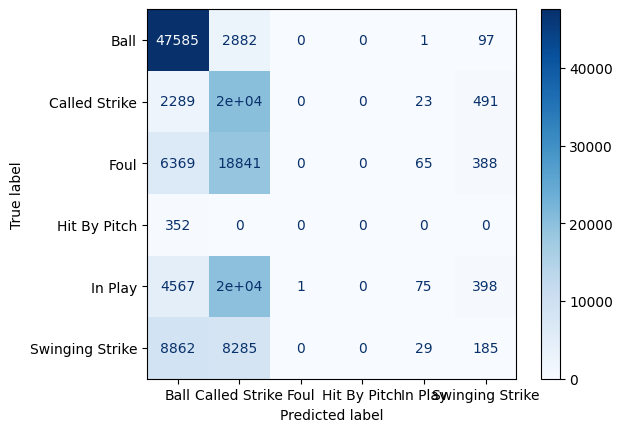

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

## 5. Improve the model

The model is still all over the place, so I'm going to start by simplifying things to make it easier for the algorithm. Instead of trying to predict what the exact outcomes of each pitch will be, I will break it down to a binary outcome; strike or no strike.

In [39]:
# I think I want to simplify the target to just is it a strike or not
# What we really care about is getting strikes and avoiding everything else
# First let's remind ourselves of the useful_df DataFrame
useful_df.head()

,pitch_type,release_speed,release_pos_x,release_pos_y,release_pos_z,pitcher_name,batter_name,zone,p_throws,stand,pfx_x,pfx_z,vx0,vy0,vz0,ax,ay,az,release_spin_rate,release_extension,target,in_play_result
0,FF,95.7,-2.15,54.67,5.21,"Weissert, Greg","Meadows, Parker",1,R,L,-0.71,0.93,6.169368,-139.262184,-2.088523,-10.601017,31.025947,-19.832498,2370.0,5.8,In Play,Out
1,FF,95.1,-1.91,53.86,5.1,"Weissert, Greg","Rogers, Jake",6,R,R,-0.93,0.93,8.617368,-138.217784,-3.023825,-13.845463,30.454633,-19.764496,2309.0,6.6,Called Strike,NaN
2,FF,95.4,-1.99,54.75,5.22,"Weissert, Greg","Rogers, Jake",2,R,R,-0.85,1.14,7.213709,-138.740928,-1.962713,-12.54588,30.045431,-17.188392,2314.0,5.8,Foul,NaN
3,SL,84.8,-2.33,54.14,4.72,"Weissert, Greg","Rogers, Jake",5,R,R,0.32,0.62,5.156934,-123.459684,0.134447,2.225813,24.4588,-26.088975,2528.0,6.4,Swinging Strike,NaN
4,SL,85.3,-2.26,54.55,4.85,"Weissert, Greg","Rogers, Jake",12,R,R,0.52,0.41,6.425252,-124.208027,0.091855,4.131948,23.966198,-28.183591,2548.0,5.9,Called Strike,NaN


In [40]:
useful_df['target'].value_counts()

target
Ball               253103
Foul               128493
In Play            124774
Called Strike      115464
Swinging Strike     85508
Hit By Pitch         1927
Name: count, dtype: int64

In [41]:
# Now let's create a new target column called is_strike
useful_df['is_strike'] = useful_df['target'].apply(lambda x: 1 if x in ['Called Strike', 'Swinging Strike', 'Foul'] else 0)
useful_df['is_strike'].value_counts()

C:\Users\dalli\AppData\Local\Temp\ipykernel_5340\1870638733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  useful_df['is_strike'] = useful_df['target'].apply(lambda x: 1 if x in ['Called Strike', 'Swinging Strike', 'Foul'] else 0)


is_strike
0    379804
1    329465
Name: count, dtype: int64

In [42]:
useful_df.isna().sum()

pitch_type                0
release_speed             0
release_pos_x             0
release_pos_y             0
release_pos_z             0
pitcher_name              0
batter_name               0
zone                      0
p_throws                  0
stand                     0
pfx_x                     0
pfx_z                     0
vx0                       0
vy0                       0
vz0                       0
ax                        0
ay                        0
az                        0
release_spin_rate         0
release_extension         0
target                    0
in_play_result       584420
is_strike                 0
dtype: int64

In [ ]:
# Now let's import train_test_split again and create new X & y with is_strike as the target
from sklearn.model_selection import train_test_split

# Split into X & y
X = useful_df.drop(columns=['target', 'in_play_result', 'pitcher_name', 'batter_name', 'is_strike'], axis=1)
y = useful_df['is_strike']

# Categorize the categorical columns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = ['pitch_type', 'p_throws', 'stand', 'zone']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot', one_hot, categorical_cols)], remainder='passthrough')

X_encoded = transformer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instantiate the model
clf = SGDClassifier(loss='hinge', max_iter=2000, random_state=42)

# Train model
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_preds))

Accuracy: 0.4736066660087132


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instantiate the model
# I will keep track here of different loss functions and their accuracies to keep it all in this cell
# hinge (above): 0.4736066660087132
# log_loss: 0.623690555077756
# modified_huber: 0.5233690978047852
# squared_hinge: 0.7121970476687298
# perceptron: 0.5354871910555924
clf = SGDClassifier(loss='perceptron', max_iter=2000, random_state=42)

# Train model
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_preds))

Accuracy: 0.5354871910555924


In [53]:
# squared_hinge seems to outperform the other loss methods, so let's stick with that
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Instantiate the model
clf = SGDClassifier(loss='squared_hinge', max_iter=2000, random_state=42)

# Train model
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_preds))

Accuracy: 0.7121970476687298


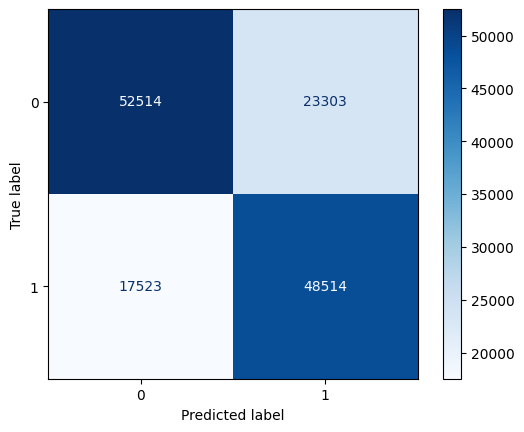

In [54]:
# Let's check out a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

So this model gives us:
* 52,514 true negatives (correctly predicted non-strikes)
* 48,514 true positives (correctly predicted strikes)
* 17,523 false negatives (strikes that were incorrectly predicted as non-strikes)
* 23,303 false positives (non-strikes that were incorrectly predicted as strikes)

### Classification Report

In [56]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72     75817
           1       0.68      0.73      0.70     66037

    accuracy                           0.71    141854
   macro avg       0.71      0.71      0.71    141854
weighted avg       0.72      0.71      0.71    141854



In [59]:
# Now let's save the model
import pickle

pickle.dump(clf, open("sgdclassifier_model.pkl", "wb"))

### Next steps

- This model will be used in a larger project that takes allows users to select a pitcher, a pitch type from that pitcher's arsenal, and an area within an image of a strike zone in order to simulate if that exact pitch would result in a strike or not
- Future improvements could include more advanced stats, weather and stadium effects, and pitcher-batter matchups
- This model only predicts whether a pitch results in a strike or not. Future versions may dive in deeper to predict type of strike (swinging strike, caught looking, foul ball, etc) to help pitchers and their coaches understand which pitches can produce desired results